<a href="https://colab.research.google.com/github/apoorvsingh090/SMSSpam/blob/main/SMS_SPAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O dataset.zip "https://primeroomlink.herokuapp.com/9075802710278080/archive_2.zip"
!unzip "dataset.zip"

--2021-04-18 14:37:05--  https://primeroomlink.herokuapp.com/9075802710278080/archive_2.zip
Resolving primeroomlink.herokuapp.com (primeroomlink.herokuapp.com)... 3.219.96.23, 23.22.144.165, 23.22.52.7, ...
Connecting to primeroomlink.herokuapp.com (primeroomlink.herokuapp.com)|3.219.96.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215934 (211K) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 210.87K   158KB/s    in 1.3s    

2021-04-18 14:37:07 (158 KB/s) - ‘dataset.zip’ saved [215934/215934]

Archive:  dataset.zip
  inflating: spam.csv                


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
dataset=pd.read_csv("spam.csv",encoding='latin-1')


In [4]:
dataset['Unnamed: 2'].fillna("",inplace=True)
dataset['Unnamed: 3'].fillna("",inplace=True)
dataset['Unnamed: 4'].fillna("",inplace=True)
dataset['new']=dataset['v2']+dataset['Unnamed: 2']+dataset['Unnamed: 3']+dataset['Unnamed: 4']
dataset['v1']=(dataset['v1']=="spam").astype(int)
dataset.drop(['v2','Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [5]:
dataset.head()

,v1,new
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
from imblearn.over_sampling import RandomOverSampler
import collections
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(dataset[dataset.columns.drop(['v1'])], dataset['v1'])

print(collections.Counter(dataset['v1']),collections.Counter(y))


Counter({0: 4825, 1: 747}) Counter({0: 4825, 1: 4825})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [27]:
X=pd.DataFrame({'text': X[:, 0]})


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
training_sentences = X['text'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [9]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)

In [10]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

# Creating texts 
my_texts = list(map(sequence_to_text, training_sequences))


In [11]:
j=[]
for i in range(len(my_texts)):
  j.append(str(' '.join(my_texts[i])))

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(j).toarray()


In [16]:
from sklearn.model_selection import train_test_split

trainx,testx,trainy,testy = train_test_split(x,y,test_size=0.2,random_state=2)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=1000,max_depth=100,random_state=1,max_features=1)
rf_model.fit(trainx, trainy)
rf_test_predictions = rf_model.predict(testx)
rf_test_mae = accuracy_score(rf_test_predictions, testy)
print(rf_test_mae)

0.9901554404145078


In [18]:
from sklearn import svm
svmclf_model = svm.SVC()
svmclf_model.fit(trainx, trainy)
svc = svmclf_model.predict(testx)
svm_mae = accuracy_score(svc, testy)
print(svm_mae)

0.9989637305699481


In [19]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=0,max_iter=1000)
logreg.fit(trainx, trainy)
logregpred = logreg.predict(testx)
logreg_mae = accuracy_score(logregpred, testy)
print(logreg_mae)

0.9984455958549223


In [20]:
from xgboost import XGBClassifier

my_model_1 = XGBClassifier(random_state=0)

my_model_1.fit(trainx, trainy)
xgpredictions=my_model_1.predict(testx)
print(accuracy_score(xgpredictions, testy))


0.9590673575129534


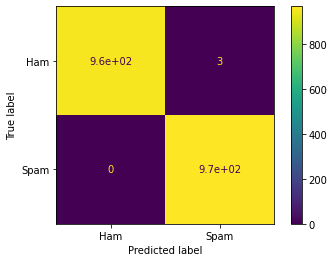

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testy, logregpred),display_labels=['Ham','Spam'])
disp.plot()

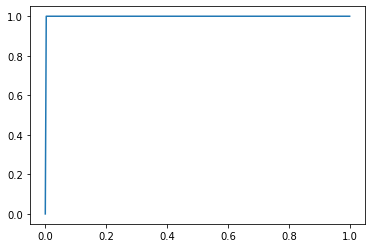

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testy, logregpred)
plt.plot(fpr,tpr)